In [54]:
import logging
logging.basicConfig(filename='regressing-manski.log', level=logging.INFO)

In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")

In [35]:
col_name = 'Temp_C'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [36]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [266]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [299]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [324]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2][[
       'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR',
       'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
       'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
       'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
       'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
       'Arterial_BE', 'HCO3', 'Arterial_lactate']].reset_index()

MIMICtable_filtered_t0 = MIMICtable_filtered_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[col_name]>0].reset_index()
MIMICtable_filtered_t1 = MIMICtable_filtered_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index()
MIMIC_data_combined = MIMICtable_filtered_t0[['gender', 'age', 'icustay_id', f'{col_name}_t0']].merge(MIMICtable_filtered_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
MIMIC_data_combined.head()

,gender,age,icustay_id,Temp_C_t0,Temp_C_t1
0,0.0,22799.404780,65537,35.833333,35.833333
1,0.0,17639.826435,3,37.444445,37.444445
2,0.0,24000.436400,65544,37.111113,37.444445
3,0.0,23940.093773,98314,36.333334,36.444446
4,0.0,30946.970000,14,36.999999,37.000000


In [311]:
pulse_data_t0 = pulse_data[pulse_data['index']==0].reset_index(drop=True)
pulse_data_t1 = pulse_data[pulse_data['index']==1].reset_index(drop=True)
pulse_data_t0 = pulse_data_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
pulse_data_t1 = pulse_data_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
pulse_data_combined = pulse_data_t0[['icustay_id', f'{col_name}_t0']].merge(pulse_data_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
pulse_data_combined = MIMICtable_filtered_t0[['gender', 'age', 'icustay_id']].merge(pulse_data_combined[['icustay_id', f'{col_name}_t0', f'{col_name}_t1']], on=['icustay_id'])
pulse_data_combined.head()

,gender,age,icustay_id,Temp_C_t0,Temp_C_t1
0,0.0,22799.404780,65537,33.151252,32.223820
1,0.0,17639.826435,3,33.130515,32.814843
2,0.0,24000.436400,65544,33.190942,33.551028
3,0.0,23940.093773,98314,33.237951,34.493438
4,0.0,30946.970000,14,33.112334,32.445347


# Supervised Learning of Actions - Logistic Regression


In [312]:
nra = 5
nr_reps = 10

In [313]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

MIMICraw = MIMIC_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
#     elif col in colnorm:
    else:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
#     else:
#         log_values = np.log(0.1 + MIMICraw[col])
#         dmu = log_values.mean()
#         dsigma = log_values.std()
#         MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


In [314]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

pulseraw = pulse_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

for col in pulseraw:
    if col in colbin:
        pulseraw[col] = pulseraw[col] - 0.5
#     elif col in colnorm:
    else:
        cmu = pulseraw[col].mean()
        csigma = pulseraw[col].std()
        pulseraw[col] = (pulseraw[col] - cmu)/csigma
#     else:
#         log_values = np.log(0.1 + MIMICraw[col])
#         dmu = log_values.mean()
#         dsigma = log_values.std()
#         MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


## Create Actions


In [325]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable_filtered_t0)) # array of ones, by default
io[MIMICtable_filtered_t0['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable_filtered_t0['max_dose_vaso'].copy()
vc_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable_filtered_t0.loc[io==1, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==2, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==3, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==4, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable_filtered_t0.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [326]:
len(actionbloc)

6174

## Fitting models

In [327]:
from sklearn.linear_model import LogisticRegression
icuuniqueids = MIMIC_data_combined['icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')

for model in tqdm(range(nr_reps)):
    logging.info('Model: ' + str(model))
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = MIMICraw.loc[MIMIC_data_combined['icustay_id'].isin(trainidx)]
    Xtestmimic = MIMICraw[MIMIC_data_combined['icustay_id'].isin(testidx)]
    ptid = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'icustay_id']
    Y = actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc']
    Ytest = actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc']
    clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
    acc_train = clf.score(X, Y)
    acc_test = clf.score(Xtestmimic, Ytest)
    modelsDf = modelsDf.append({'model': model, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


In [328]:
clf.predict_proba(Xtestmimic)

array([[0.00338303, 0.5535682 , 0.09395559, ..., 0.00441616, 0.00457606,
        0.00556447],
       [0.00289462, 0.54099984, 0.08685781, ..., 0.00412265, 0.00506392,
        0.00484346],
       [0.00318151, 0.55113236, 0.08958838, ..., 0.00441868, 0.00491176,
        0.00522638],
       ...,
       [0.00287486, 0.5026674 , 0.1038893 , ..., 0.00467145, 0.0025709 ,
        0.00677331],
       [0.00270926, 0.52568573, 0.07943088, ..., 0.00664237, 0.00402198,
        0.00573729],
       [0.00320445, 0.55092694, 0.09046078, ..., 0.00438982, 0.00483739,
        0.00527513]])

In [329]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.518139,0.525683,0.0,"LogisticRegression(C=1.0, class_weight=None, d..."
1,0.540193,0.519878,1.0,"LogisticRegression(C=1.0, class_weight=None, d..."
2,0.522989,0.524415,2.0,"LogisticRegression(C=1.0, class_weight=None, d..."
3,0.522979,0.524430,3.0,"LogisticRegression(C=1.0, class_weight=None, d..."
4,0.535494,0.520910,4.0,"LogisticRegression(C=1.0, class_weight=None, d..."
5,0.535519,0.521153,5.0,"LogisticRegression(C=1.0, class_weight=None, d..."
6,0.519460,0.525331,6.0,"LogisticRegression(C=1.0, class_weight=None, d..."
7,0.513449,0.526884,7.0,"LogisticRegression(C=1.0, class_weight=None, d..."
8,0.497041,0.530355,8.0,"LogisticRegression(C=1.0, class_weight=None, d..."
9,0.507594,0.528133,9.0,"LogisticRegression(C=1.0, class_weight=None, d..."


# Regressing $\mathbb{E}[Y^{obs}\mid x,a]$

In [330]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [331]:
net = Net(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=1)
loss_func = torch.nn.MSELoss()

In [332]:
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)


In [333]:
prediction = net(X)

In [334]:
# train the network
losses = []
for t in tqdm(range(1000)):
  
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 1000/1000 [00:00<00:00, 2337.44it/s]


0.6561123728752136

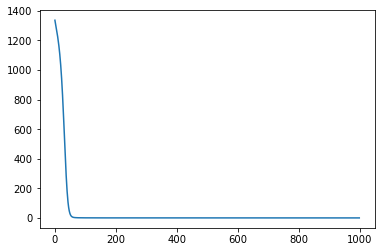

In [335]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [336]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
net(x)

tensor([35.6614], grad_fn=<AddBackward0>)

In [337]:
X

tensor([[-0.5000, -0.1808, -0.9452],
        [-0.5000, -1.0452,  0.5158],
        [-0.5000,  1.1843,  0.1128],
        ...,
        [-0.5000, -0.0385, -0.5422],
        [ 0.5000,  1.5926,  1.1204],
        [ 0.5000,  0.7394, -0.1895]])

# Regressing $\mathbb{E}[Y^{min}\mid x,a]$

In [338]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [339]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [340]:
quantile_net = Net(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = PinballLoss(quantile=0.01, reduction='mean')

In [341]:
# train the network
losses = []
for t in tqdm(range(5000)):
  
    prediction = quantile_net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(quantile_net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 5000/5000 [00:04<00:00, 1073.19it/s]


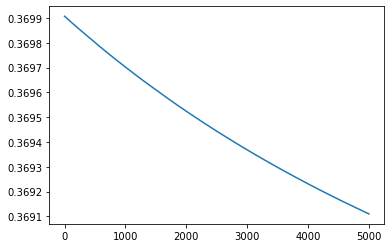

In [342]:
plt.plot(losses)

In [343]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
quantile_net(x)

tensor([-0.0985], grad_fn=<AddBackward0>)

In [344]:
losses[2000]

0.36952394247055054

# Regressing $\mathbb{E}[Y^{max}\mid x,a]$

In [345]:
quantile_net = Net(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.99, reduction='mean')

In [346]:
# train the network
losses = []
for t in tqdm(range(5000)):
  
    prediction = quantile_net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(quantile_net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 5000/5000 [00:04<00:00, 1076.68it/s]


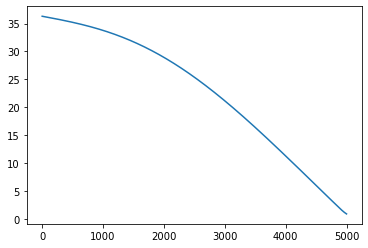

In [347]:
plt.plot(losses)

In [348]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
quantile_net(x)

tensor([36.1642], grad_fn=<AddBackward0>)

# Regressing $\mathbb{E}[Y^{sim}(a)\mid x]$

In [355]:
net = Net(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [356]:
icuuniqueids = pulse_data_combined['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(pulseraw.loc[pulse_data_combined['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(pulseraw[pulse_data_combined['icustay_id'].isin(testidx)].values)
ptid = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)


In [357]:
prediction = net(X)

In [358]:
# train the network
losses = []
for t in tqdm(range(1000)):
  
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 1000/1000 [00:00<00:00, 1999.48it/s]


0.504423201084137

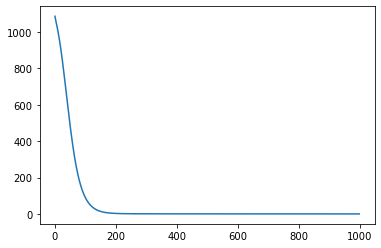

In [359]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [360]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
net(x)

tensor([32.6433], grad_fn=<AddBackward0>)